# **Attention is all you need using PyTorch**

This project is aim to recreate the transformer research paper "Attention is all you need" using the Python deep learning framework PyTorch. And the data, used in this project is the sub-set of the dataset used in the original paper "WMT 2014 English-to-French.
Link for the dataset - https://www.statmt.org/wmt14/translation-task.html




###Project Overview

The project involves the following steps.



**1. Scaled dot product attention -** The input of this function consists of queries (q = 64), keys (k = 64) of dimensions d_k (= 512) and the values of the dimension (v = 64).
We compute the scale product of queries (q) and keys (k), then divide the product by √d_k and apply the softmax function to obtain the weights on the attention. And at last, again taking a dot product of the attention obtained and values (v).



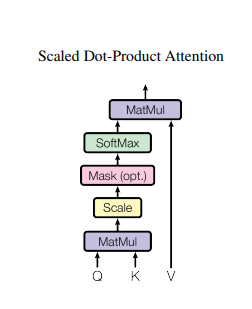

In [ ]:
# Dependencies

import numpy as np
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def scaled_dot_product(q, v, k, mask = None):
  """
  q, k, v is of dimension 30, 8, 200, 64
  d_k is of dimension 64
  """
  d_k = q.size()[-1]

  # dim(scaled) = 30, 8, 200, 200
  scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
  if mask is not None:
    scaled = scaled.permute(1, 0, 2, 3) + mask
    scaled = scaled.permute(1, 0, 2, 3)

  # dim(attention) =  30, 8, 200, 200
  attention = F.softmax(scaled, dim = -1)

  #dim(values) = 30, 8, 200, 64
  values = torch.matmul(attention, v)
  return values, attention

:**2. Multi Head Attention :** In this, we will first make a qkv_layer using x (of dim 30, 200, 512) as the input and we will get the output qkv of dim 30, 200, 1536 then reshaping it into 30, 200, 8, 512 then again permuting it into 30, 8, 200, 512. Now dividing the whole qkv into 3 parts each of dim 30, 8, 200, 64 and passing it through the dot product attention. Changing the dimension of the output of the scaled dot product to 30, 200, 512.

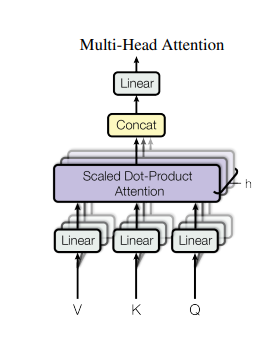

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads):
    """
    dim(d_model) = 512
    dim(num_heads) = 8
    dim(head_dim) = 64
    (qkv_linear) = 512, 1536
    dim(linear_layer) = 512, 512
    """
    super().__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads
    self.qkv_layer = nn.Linear(d_model, 3 * d_model)
    self.linear_layer = nn.Linear(d_model, d_model)

  def forward(self, x, mask = None):

    # dim(x) = 30, 200, 512
    batch_size, max_sequence_length, d_model = x.size()

    # dim(qkv) = 30, 200, 1536
    qkv = self.qkv_layer(x)

    # dim(qkv) = 30, 200, 8, 64
    qkv = qkv.reshape(batch_size, max_sequence_length, self.num_heads, 3 * self.head_dim)

    # dim(qkv) = 30, 8, 200, 512
    qkv = qkv.permute(0, 2, 1, 3)

    # dim(q, k, v) = 30, 8, 200, 64
    q, k, v = qkv.chunk(3, dim = -1)
    values, attention = scaled_dot_product(q, k, v, mask = None)

    # dim(values) = 30, 200, 512
    values = values.reshape(batch_size, max_sequence_length, self.num_heads * self.head_dim)

    # dim(out) = 30, 200, 512
    out = self.linear_layer(values)
    return out

**3. Position-wise Feed-Forward Networks -** Both encoding and decoding layers have these fully connected ffn layers(feed-forward network layers) with ReLU as the activation function.

Each ffn layer consist of 2 linear layers with dropout set as 0.1.

In [ ]:
class PositionWiseForward(nn.Module):
  def __init__(self, d_model, hidden, drop_prob = 0.1):
    """
    dim(d_model) = 512
    dim(hidden) = 2048   # based on the research paper
    """
    super().__init__()

    # dim(linear_1) = 512, 2048
    self.linear_1 = nn.Linear(d_model, hidden)

    # dim(linear_2) = 2048, 512
    self.linear_2 = nn.Linear(hidden, d_model)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p = drop_prob)

  def forward(self, x):
    x = self.linear_1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.linear_2(x)
    return x

**4. Positional Encoding -** It is a crucial component for allowing the model to understand the sequential order of the input tokens in sequence. This is particularly important because the Transformer doesn't possess sequential information like Recurrent Neural Networks (RNN) or Convolutional Neural Networks (CNN). In this project, we use sine and cosine functions of different frequencies.

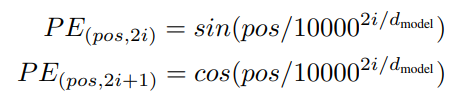

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_sequence_length):
    """
    dim(d_model) = 512
    dim(max_sequence_length) = 200
    """
    super().__init__()
    self.d_model = d_model
    self.max_sequence_length = max_sequence_length

  def forward(self):
    even_i = torch.arange(0, self.max_sequence_length, 2).float()

    denominator = torch.pow(10000, even_i/self.d_model)
    position = (torch.arange(self.max_sequence_length)
                     .reshape(self.max_sequence_length, 1))

    even_PE = torch.sin(position/denominator)
    odd_PE = torch.cos(position/denominator)

    stacked = torch.stack([even_PE, odd_PE], dim = 2)

    PE = torch.flatten(stacked, start_dim = 1, end_dim =2)
    return PE